In [1]:
from Model import NeuralNetwork

import numpy as np
import pandas as pd
import time
import logging
import seaborn as sns

from sklearn import preprocessing
from joblib import load

import torch
import torch.nn as nn
#torch._dynamo.config.verbose=True

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
#Define directory for the input and output files 
DATA_DIR = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/'

#Define input location on the the training data 
TRAINING_DATASET = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/TrainingDataset1000000/2000000MassSpinTrainingDataset.csv'

TEST_DATASET = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/OneMillionMatchDataset.csv'

MASS_TEST_DATASET = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass2936Spin22.csv'

MASS_TEST_DATASET2 = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass314Spin22.csv'

MASS_TEST_DATASET3 = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass2936Spin7171.csv'

MASS_TEST_DATASET4 = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass9667Spin22.csv'

MASS_TEST_DATASET5 = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass412Spin7171.csv'

MASS_TEST_DATASET6 = '/users/sgreen/LearningMatch/LVK/Paper/MassSpinParameters/Debug/Problems/5000RefMass2936Spin7676.csv'

#Define input location of the Standard.Scaler()
STANDARD_SCALER = DATA_DIR+'2000000StandardScaler.bin'

#Define input location of the LearningMatch model
LEARNINGMATCH_MODEL = DATA_DIR+'LearningMatchModel_2.pth'

In [3]:
#Define functions
def sorting_the_mass(m1, m2):
    if m1>m2:
        return m1, m2
    else:
        return m2, m1

def scaling_the_mass(mass, mean, std):
    return (mass - mean)/np.sqrt(std)

def rescaling_the_mass(scaled_mass, mean, std):
    return (scaled_mass*np.sqrt(std)) + mean  

def to_np(x):
    return x.cpu().detach().numpy()
    

In [4]:
#Loading the scaler to determine the mean and variance
scaler = load(STANDARD_SCALER)
scaler_mean = float(np.mean(scaler.mean_))
scaler_std = float(np.mean(scaler.var_))
print(f'IMPORTANT: The average mean of the standard scaler is {scaler_mean}')
print(f'IMPORTANT: The average standard deviation of the standard scaler is {scaler_std}')

#Loading the training dataset to determine the minimum and maximum range
TrainingDataset = pd.read_csv(TRAINING_DATASET)
TrainingDataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(TrainingDataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])
ScaledMassDataset = TrainingDataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']].copy()
mimimum_mass = float(np.mean(ScaledMassDataset.min().values)) 
maximum_mass = float(np.mean(ScaledMassDataset.max().values))
print(f'IMPORTANT: The minimum scaled mass is {mimimum_mass}')
print(f'IMPORTANT: The maximum scaled mass is {maximum_mass}')

IMPORTANT: The average mean of the standard scaler is 51.472893946813464
IMPORTANT: The average standard deviation of the standard scaler is 784.1869345682488
IMPORTANT: The minimum scaled mass is -1.7309679270770861
IMPORTANT: The maximum scaled mass is 1.732903125827241


In [5]:
TrainingDataset.head()

ref_mass1  ref_mass2  ref_spin1  ref_spin2     mass1     mass2     spin1   
0   0.812086  -0.343616   0.758971   0.800273 -1.444138  1.186890 -0.869120  \
1  -1.199791   0.354911   0.772646  -0.436859 -1.276349  0.522316  0.837514   
2  -0.289657   0.116119   0.324468   0.300425  1.652357 -0.781334 -0.094472   
3  -1.372311  -0.000734  -0.244170   0.650564  0.264705  0.214284 -0.589011   
4   0.814579  -1.283266   0.654632   0.303498  1.699475 -1.027131  0.109694   

      spin2     match  
0 -0.639514  0.545742  
1  0.486282  0.487505  
2 -0.340267  0.689921  
3  0.001185  0.423557  
4 -0.157525  0.483419

In [6]:
test_dataset = pd.read_csv(TEST_DATASET)
test_dataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(test_dataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])
test_dataset.head()

ref_mass1  ref_mass2  ref_spin1  ref_spin2     mass1     mass2     spin1   
0   1.390830   0.664039   0.259421   0.567168  1.388856  0.662988  0.259421  \
1   0.298550   1.684401   0.964220  -0.940145  0.297005  1.683871  0.964220   
2   1.596436   1.652828  -0.109464   0.254796  1.594380  1.652282 -0.109464   
3   0.165080   0.825189  -0.165667   0.129738  0.163588  0.824220 -0.165667   
4   0.914933   0.927840   0.096592   0.712523  0.913146  0.926924  0.096592   

      spin2  match  
0  0.567168    1.0  
1 -0.940145    1.0  
2  0.254796    1.0  
3  0.129738    1.0  
4  0.712523    1.0

In [7]:
x_test = np.vstack((test_dataset.ref_mass1.values, test_dataset.ref_mass2.values, test_dataset.ref_spin1.values, test_dataset.ref_spin2.values, test_dataset.mass1.values, test_dataset.mass2.values, test_dataset.spin1.values, test_dataset.spin2.values)).T
y_test = test_dataset.match.values


x_test = torch.tensor(x_test, dtype=torch.float32, device='cpu')
y_test = torch.tensor(y_test, dtype=torch.float32, device='cpu')

In [8]:
#Define the Model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.embed_output = 8
        self.embed = nn.Sequential(
              nn.Linear(4, 334), 
              nn.ReLU(), 
              nn.Linear(334, 245), 
              nn.ReLU(), 
              nn.Linear(245, 176), 
              nn.ReLU(),
              nn.Linear(176, 98), 
              nn.ReLU(), 
              nn.Linear(98, self.embed_output))
        self.crunch = nn.Sequential(
              nn.Linear(self.embed_output, 223), 
              nn.ReLU(), 
              nn.Linear(223, 176), 
              nn.ReLU(),
              nn.Linear(176, 67), 
              nn.ReLU(),  
              nn.Linear(67, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        a = self.embed(x[..., 0:4])
        b = self.embed(x[..., 4:8])
        return self.crunch((a-b)**2)

In [9]:
model = NeuralNetwork().to('cpu')
model.load_state_dict(torch.load(LEARNINGMATCH_MODEL, map_location='cpu'))
model.eval()

NeuralNetwork(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=334, bias=True)
    (1): ReLU()
    (2): Linear(in_features=334, out_features=245, bias=True)
    (3): ReLU()
    (4): Linear(in_features=245, out_features=176, bias=True)
    (5): ReLU()
    (6): Linear(in_features=176, out_features=98, bias=True)
    (7): ReLU()
    (8): Linear(in_features=98, out_features=8, bias=True)
  )
  (crunch): Sequential(
    (0): Linear(in_features=8, out_features=223, bias=True)
    (1): ReLU()
    (2): Linear(in_features=223, out_features=176, bias=True)
    (3): ReLU()
    (4): Linear(in_features=176, out_features=67, bias=True)
    (5): ReLU()
    (6): Linear(in_features=67, out_features=1, bias=True)
  )
)

In [10]:
with torch.no_grad():
    y_prediction = model(x_test) 


In [11]:
x = to_np(y_test)
y = to_np(y_prediction[:, 0])
print(x)
print(y)

[1. 1. 1. ... 1. 1. 1.]
[0.9991208  0.9991212  0.999121   ... 0.99911183 0.9991209  0.9985049 ]


Text(0.5, 0.01, 'Actual Match')

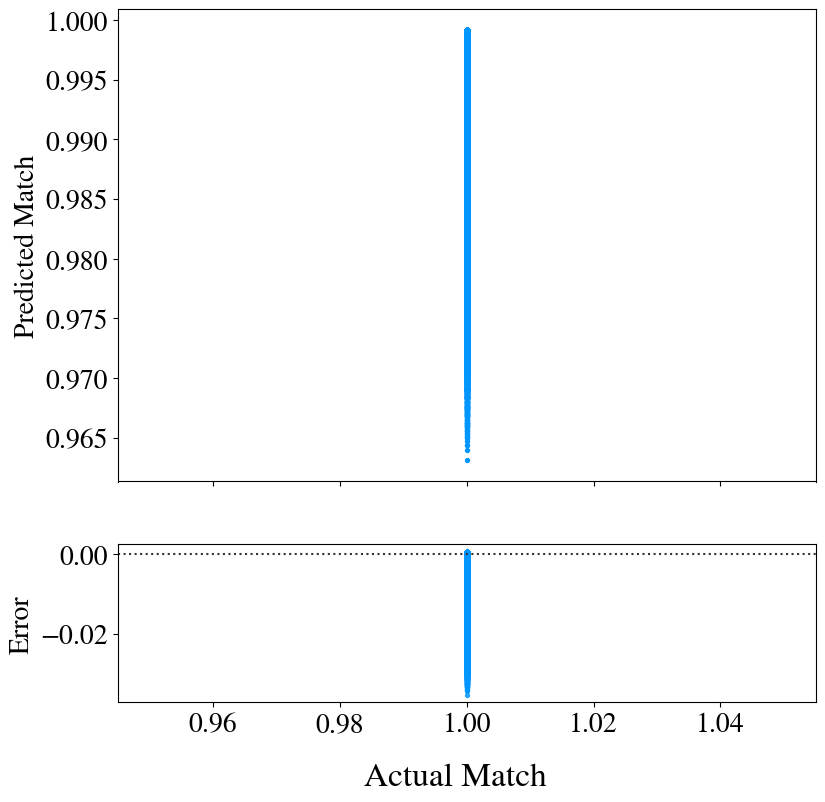

In [12]:
x = to_np(y_test)
y = to_np(y_prediction[:, 0])

fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 9), sharex=True, height_ratios=[3, 1])
ax1.scatter(x,y, s=8, color='#0096FF')
#ax1.axline((0, 0), slope=1, color='k')
ax1.set_ylabel('Predicted Match')

sns.residplot(x=x, y=y, color = '#0096FF', scatter_kws={'s': 8}, line_kws={'linewidth':20})
ax2.set_ylabel('Error')

fig.supxlabel('Actual Match')

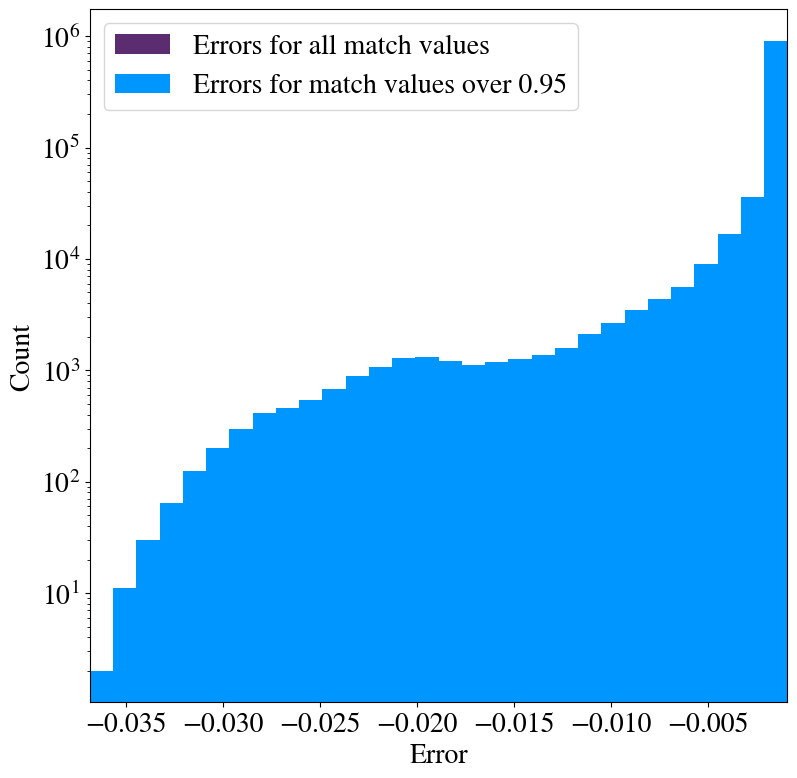

In [13]:
error = to_np(y_prediction[:, 0] - y_test)

plt.figure(figsize=(9, 9))
plt.hist(error, bins=30, range=[error.min(), error.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error[x > .95], bins=30, range=[error.min(), error.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error.min(), error.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

###### Reference Mass is 29 and 36 with spins 0.2

In [14]:
mass_test_dataset = pd.read_csv(MASS_TEST_DATASET)
mass_test_dataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test = np.vstack((mass_test_dataset.ref_mass1.values, mass_test_dataset.ref_mass2.values, mass_test_dataset.ref_spin1.values, mass_test_dataset.ref_spin2.values, mass_test_dataset.mass1.values, mass_test_dataset.mass2.values, mass_test_dataset.spin1.values, mass_test_dataset.spin2.values)).T
mass_y_test = mass_test_dataset.match.values

mass_x_test = torch.tensor(mass_x_test, dtype=torch.float32, device='cpu')
mass_y_test = torch.tensor(mass_y_test, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction = model(mass_x_test) 
    
error = to_np(mass_y_prediction[:, 0] - mass_y_test)
x = to_np(mass_y_test)

mass1 = rescaling_the_mass(to_np(mass_x_test[:, 0]), scaler_mean, scaler_std)
mass2 = rescaling_the_mass(to_np(mass_x_test[:, 1]), scaler_mean, scaler_std)

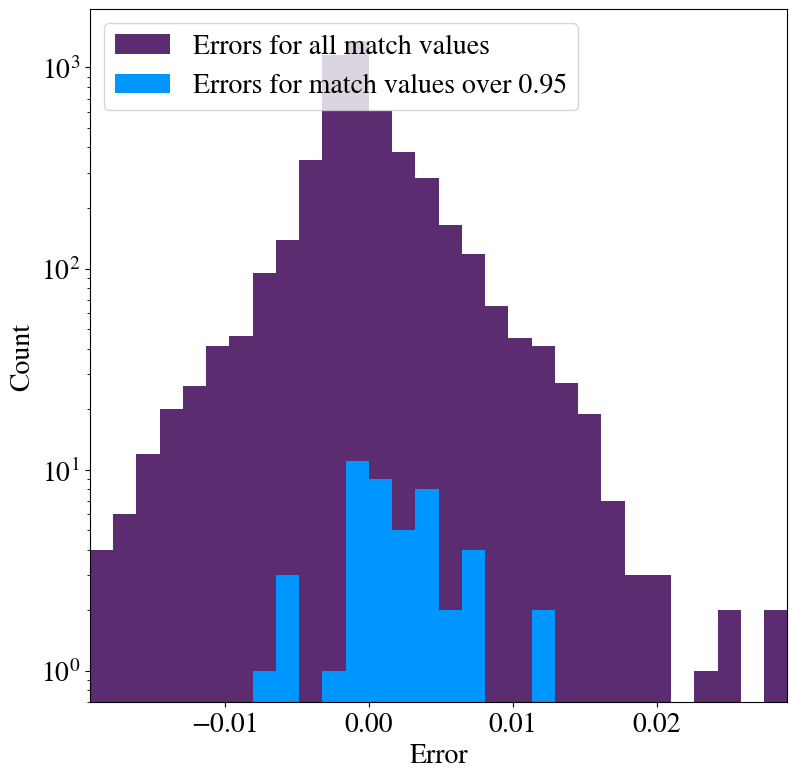

In [15]:
plt.figure(figsize=(9, 9))
plt.hist(error, bins=30, range=[error.min(), error.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error[x > .95], bins=30, range=[error.min(), error.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error.min(), error.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

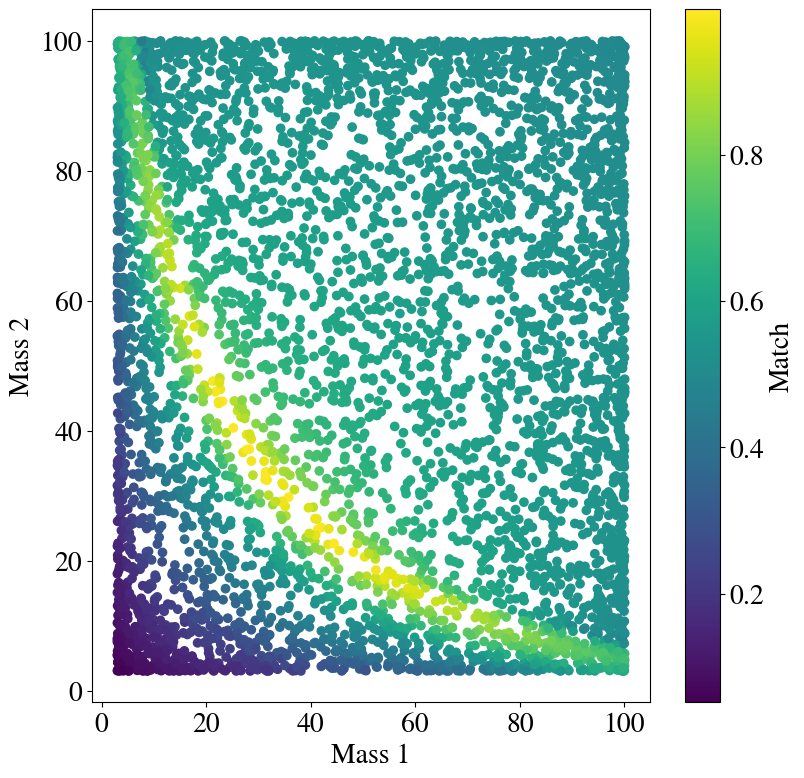

In [16]:
plt.figure(figsize=(9, 9))
plt.scatter(mass1, mass2, c=to_np(mass_y_test), label='Actual')
plt.xlabel('Mass 1')
plt.ylabel('Mass 2')
#plt.title('Actual')
plt.colorbar(label='Match')

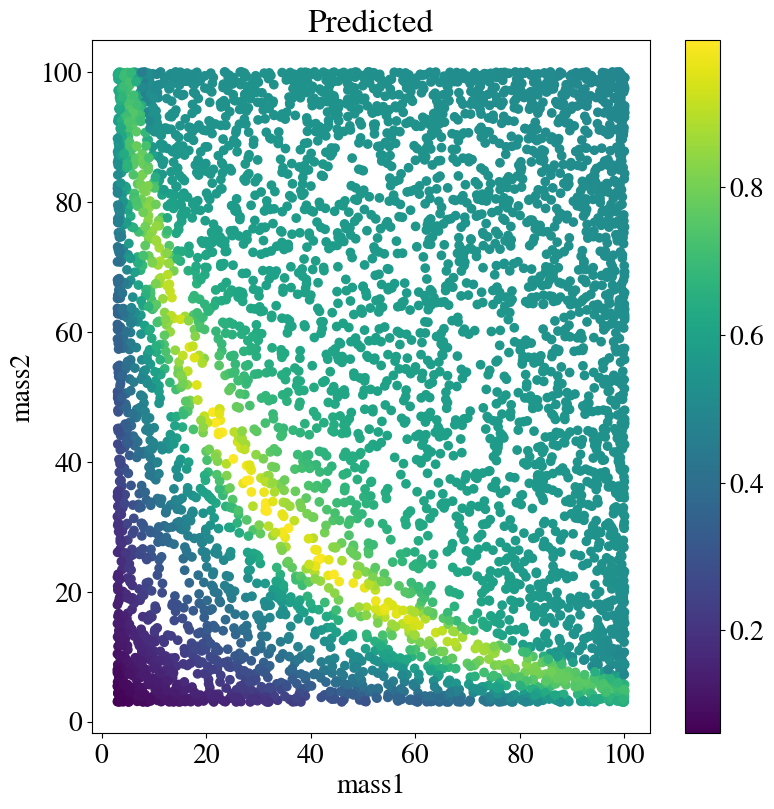

In [17]:
plt.figure(figsize=(9, 9))
plt.scatter(mass1, mass2, c=to_np(mass_y_prediction))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()

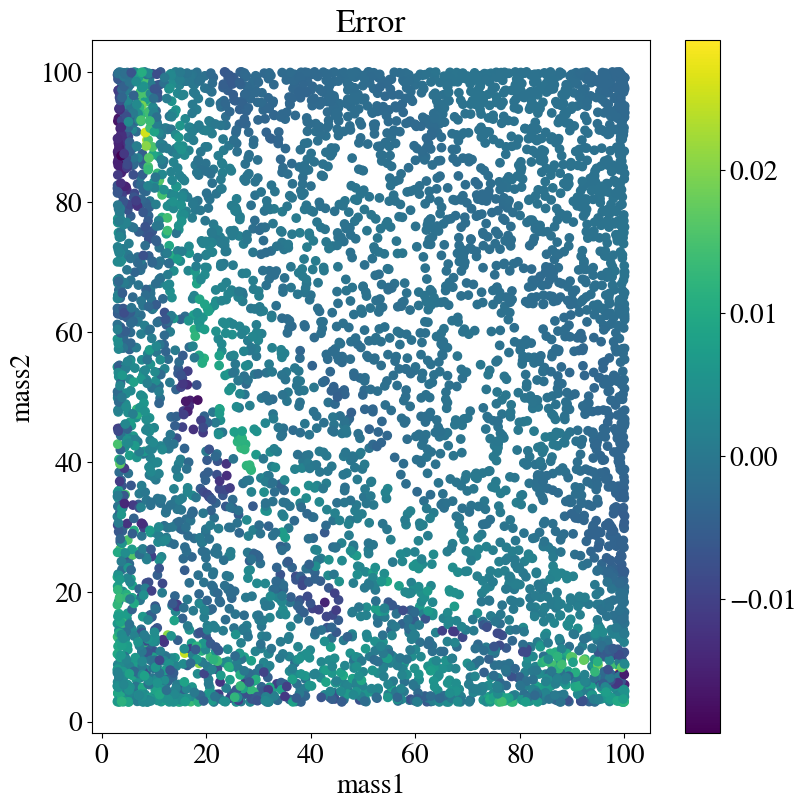

In [18]:
plt.figure(figsize=(9, 9))
plt.scatter(mass1, mass2, c=error)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Error')
plt.colorbar()

### Reference Mass is 3 and 14 with spins 0.2

In [19]:
mass_test_dataset2 = pd.read_csv(MASS_TEST_DATASET2)
mass_test_dataset2[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset2[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test2 = np.vstack((mass_test_dataset2.ref_mass1.values, mass_test_dataset2.ref_mass2.values, mass_test_dataset2.ref_spin1.values, mass_test_dataset2.ref_spin2.values, mass_test_dataset2.mass1.values, mass_test_dataset2.mass2.values, mass_test_dataset2.spin1.values, mass_test_dataset2.spin2.values)).T
mass_y_test2 = mass_test_dataset2.match.values

mass_x_test2 = torch.tensor(mass_x_test2, dtype=torch.float32, device='cpu')
mass_y_test2 = torch.tensor(mass_y_test2, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction2 = model(mass_x_test2) 
    
error2 = to_np(mass_y_prediction2[:, 0] - mass_y_test2)
x2 = to_np(mass_y_test2)

mass12 = rescaling_the_mass(to_np(mass_x_test2[:, 0]), scaler_mean, scaler_std)
mass22 = rescaling_the_mass(to_np(mass_x_test2[:, 1]), scaler_mean, scaler_std)

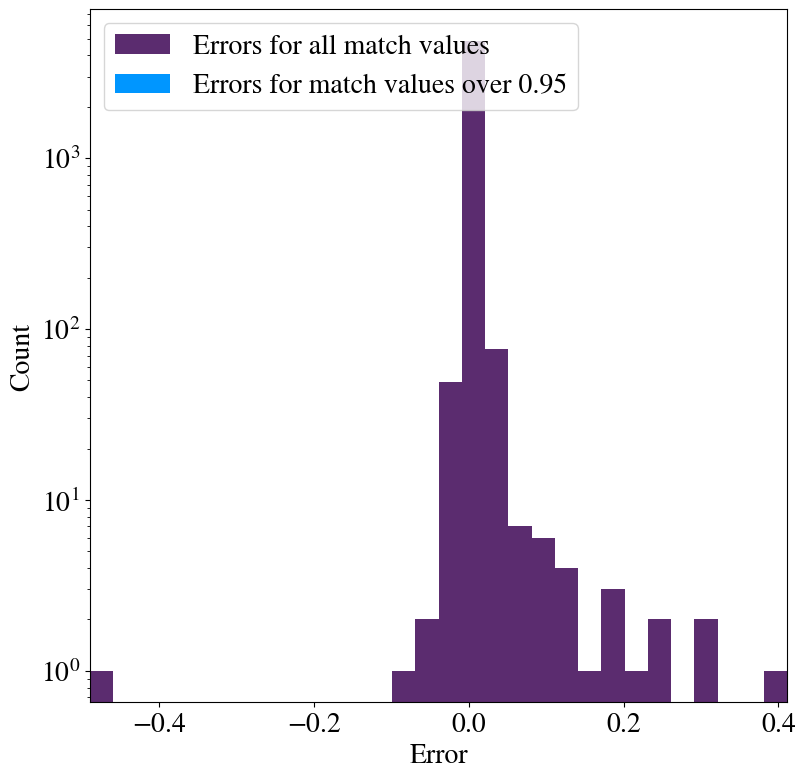

In [20]:
plt.figure(figsize=(9, 9))
plt.hist(error2, bins=30, range=[error2.min(), error2.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error2[x2 > .95], bins=30, range=[error2.min(), error2.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error2.min(), error2.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

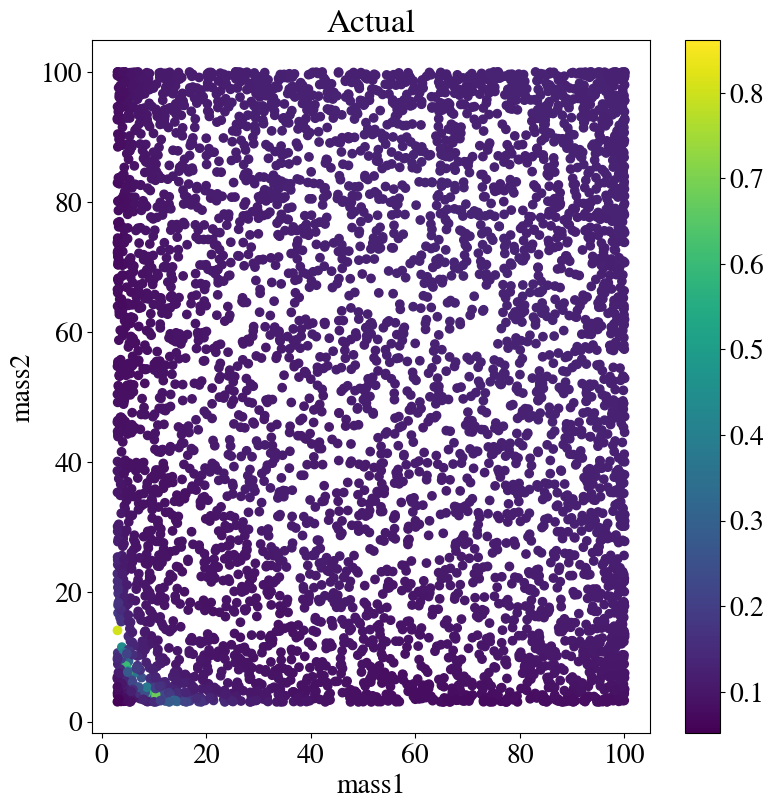

In [21]:
plt.figure(figsize=(9, 9))
plt.scatter(mass12, mass22, c=to_np(mass_y_test2), label='Actual')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Actual')
plt.colorbar()

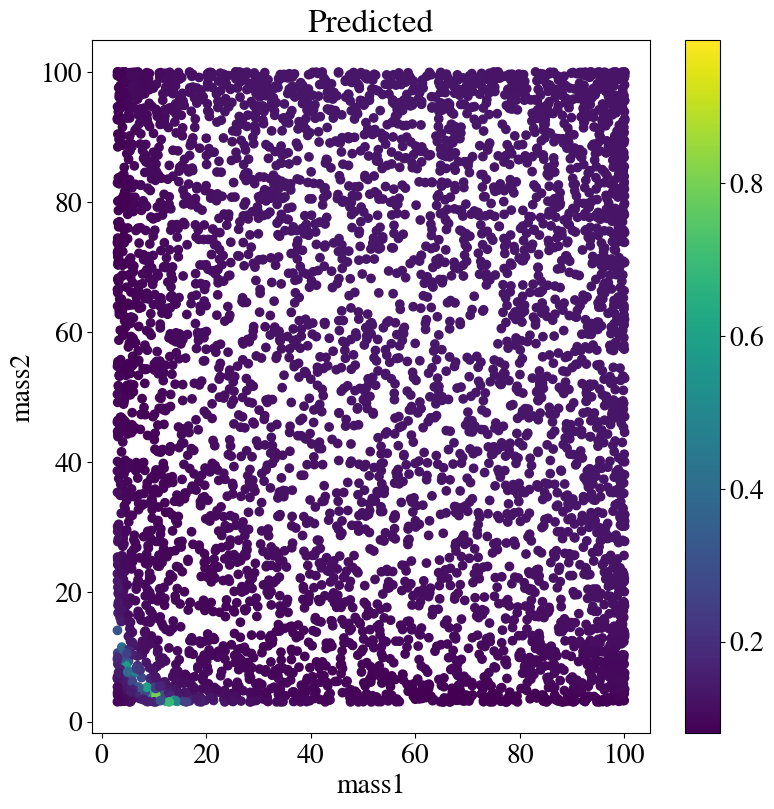

In [22]:
plt.figure(figsize=(9, 9))
plt.scatter(mass12, mass22, c=to_np(mass_y_prediction2))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()

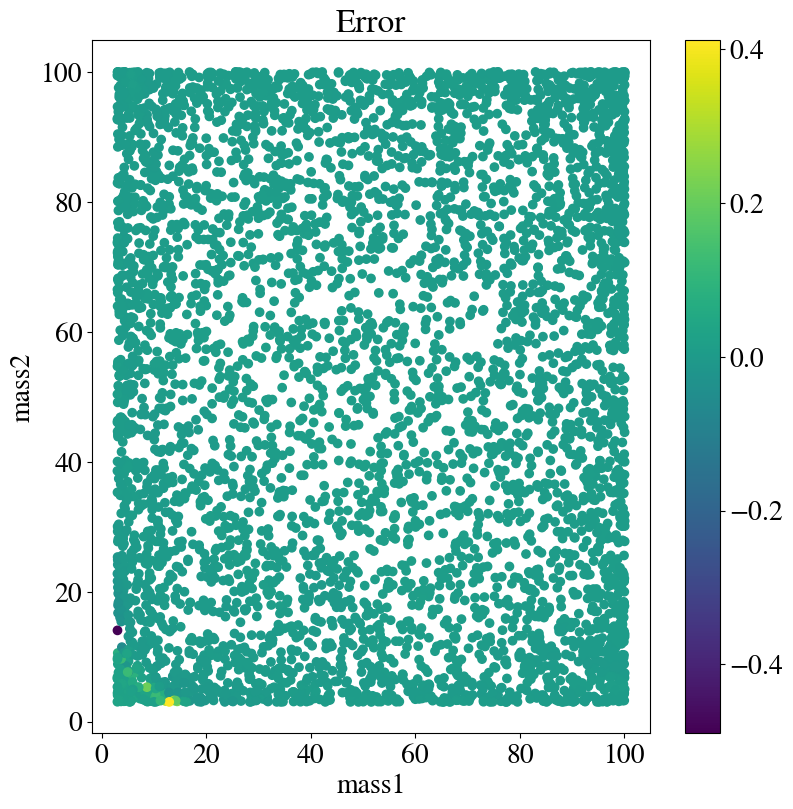

In [23]:
plt.figure(figsize=(9, 9))
plt.scatter(mass12, mass22, c=error2)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Error')
plt.colorbar()

### Reference Mass is 29 and 36 with spins -0.1 and 0.7

In [24]:
mass_test_dataset3 = pd.read_csv(MASS_TEST_DATASET3)
mass_test_dataset3[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset3[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test3 = np.vstack((mass_test_dataset3.ref_mass1.values, mass_test_dataset3.ref_mass2.values, mass_test_dataset3.ref_spin1.values, mass_test_dataset3.ref_spin2.values, mass_test_dataset3.mass1.values, mass_test_dataset3.mass2.values, mass_test_dataset3.spin1.values, mass_test_dataset3.spin2.values)).T
mass_y_test3 = mass_test_dataset3.match.values

mass_x_test3 = torch.tensor(mass_x_test3, dtype=torch.float32, device='cpu')
mass_y_test3 = torch.tensor(mass_y_test3, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction3 = model(mass_x_test3) 
    
error3 = to_np(mass_y_prediction3[:, 0] - mass_y_test3)
x3 = to_np(mass_y_test3)

mass13 = rescaling_the_mass(to_np(mass_x_test3[:, 0]), scaler_mean, scaler_std)
mass23 = rescaling_the_mass(to_np(mass_x_test3[:, 1]), scaler_mean, scaler_std)

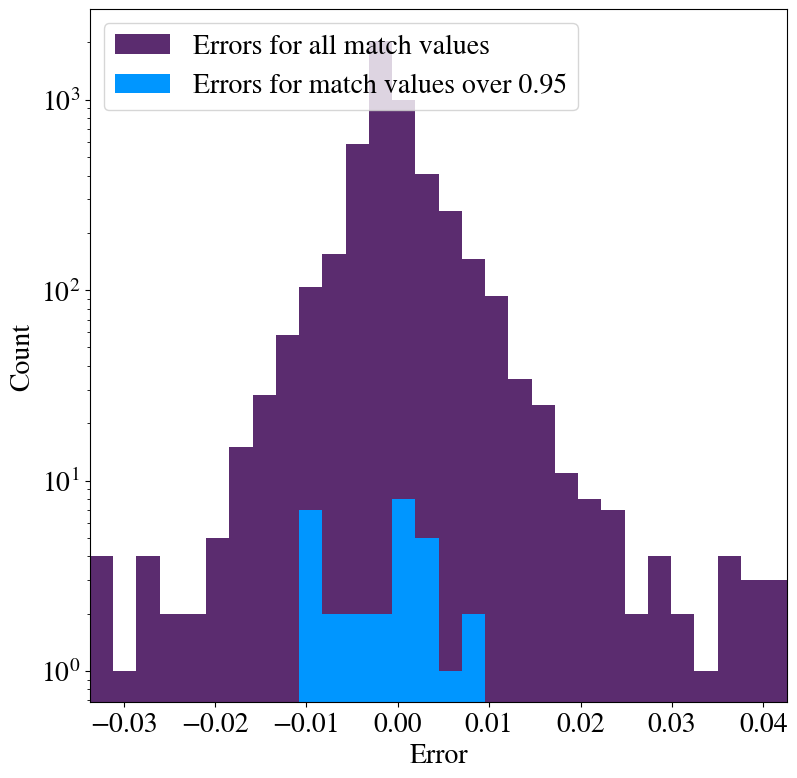

In [25]:
plt.figure(figsize=(9, 9))
plt.hist(error3, bins=30, range=[error3.min(), error3.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error3[x3 > .95], bins=30, range=[error3.min(), error3.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error3.min(), error3.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

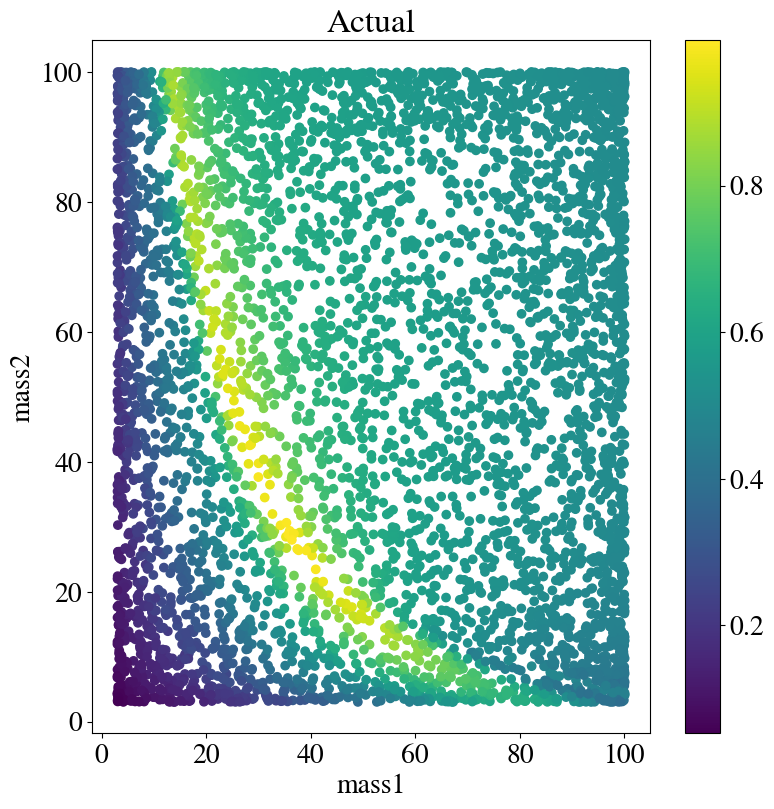

In [26]:
plt.figure(figsize=(9, 9))
plt.scatter(mass13, mass23, c=to_np(mass_y_test3), label='Actual')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Actual')
plt.colorbar()

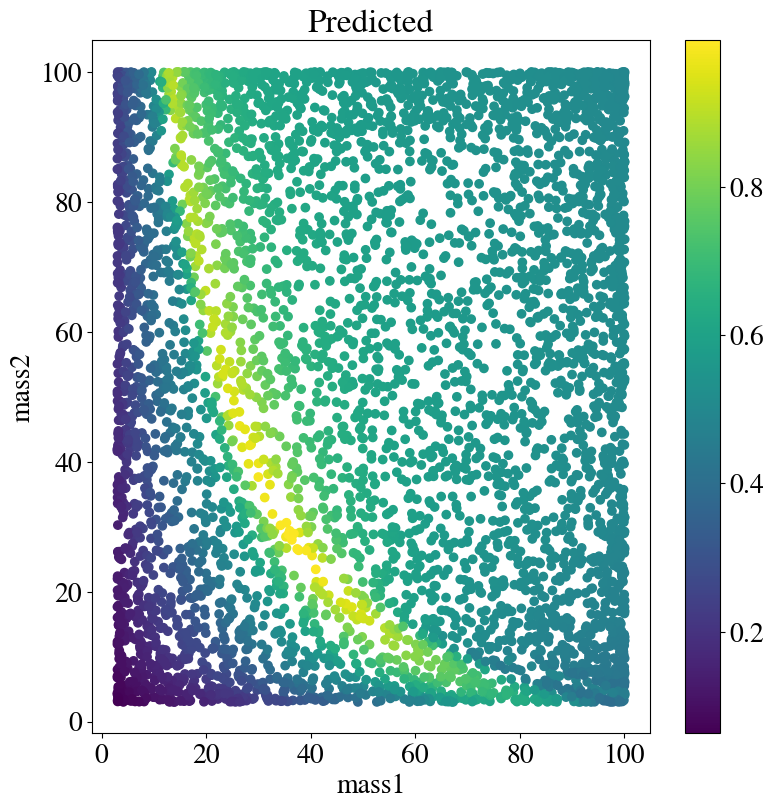

In [27]:
plt.figure(figsize=(9, 9))
plt.scatter(mass13, mass23, c=to_np(mass_y_prediction3))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()

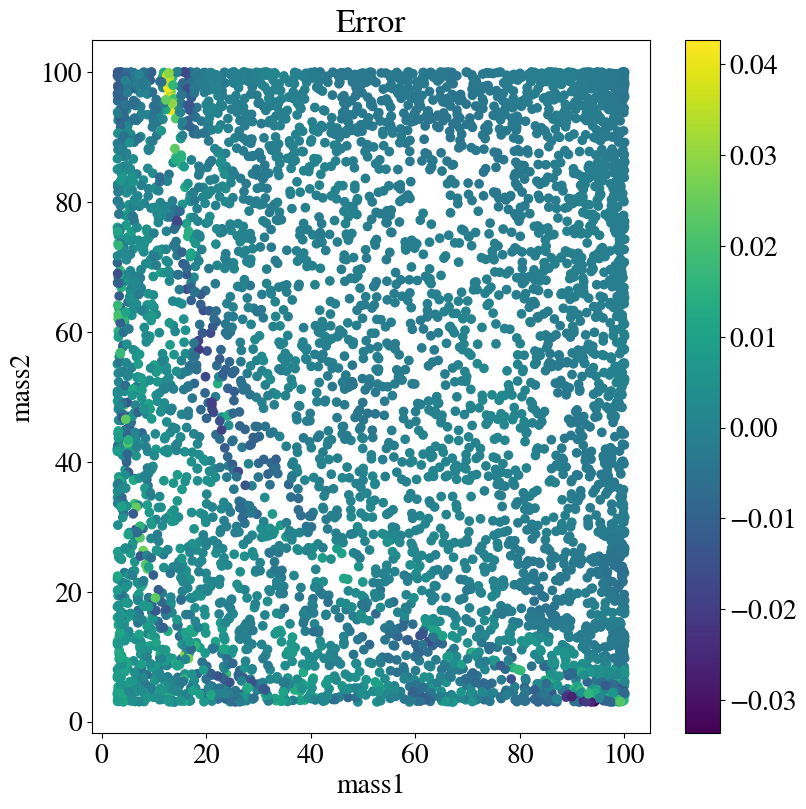

In [28]:
plt.figure(figsize=(9, 9))
plt.scatter(mass13, mass23, c=error3)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Error')
plt.colorbar()

### Reference Mass is 96 and 67 with spins 0.2

In [29]:
mass_test_dataset4 = pd.read_csv(MASS_TEST_DATASET4)
mass_test_dataset4[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset4[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test4 = np.vstack((mass_test_dataset4.ref_mass1.values, mass_test_dataset4.ref_mass2.values, mass_test_dataset4.ref_spin1.values, mass_test_dataset4.ref_spin2.values, mass_test_dataset4.mass1.values, mass_test_dataset4.mass2.values, mass_test_dataset4.spin1.values, mass_test_dataset4.spin2.values)).T
mass_y_test4 = mass_test_dataset4.match.values

mass_x_test4 = torch.tensor(mass_x_test4, dtype=torch.float32, device='cpu')
mass_y_test4 = torch.tensor(mass_y_test4, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction4 = model(mass_x_test4) 
    
error4 = to_np(mass_y_prediction4[:, 0] - mass_y_test4)
x4 = to_np(mass_y_test4)

mass14 = rescaling_the_mass(to_np(mass_x_test4[:, 0]), scaler_mean, scaler_std)
mass24 = rescaling_the_mass(to_np(mass_x_test4[:, 1]), scaler_mean, scaler_std)

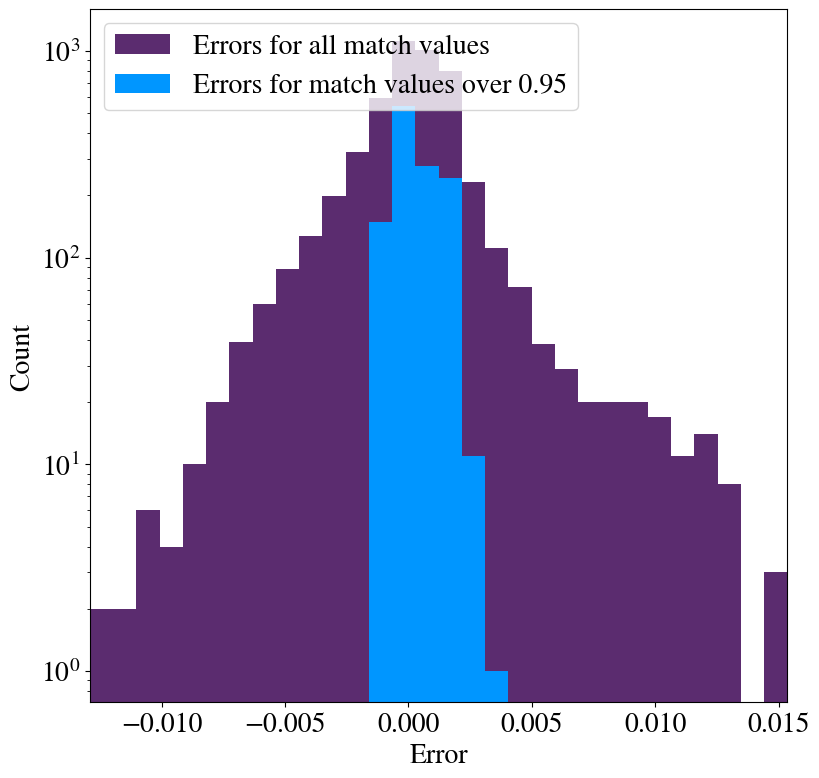

In [30]:
plt.figure(figsize=(9, 9))
plt.hist(error4, bins=30, range=[error4.min(), error4.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error4[x4 > .95], bins=30, range=[error4.min(), error4.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error4.min(), error4.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

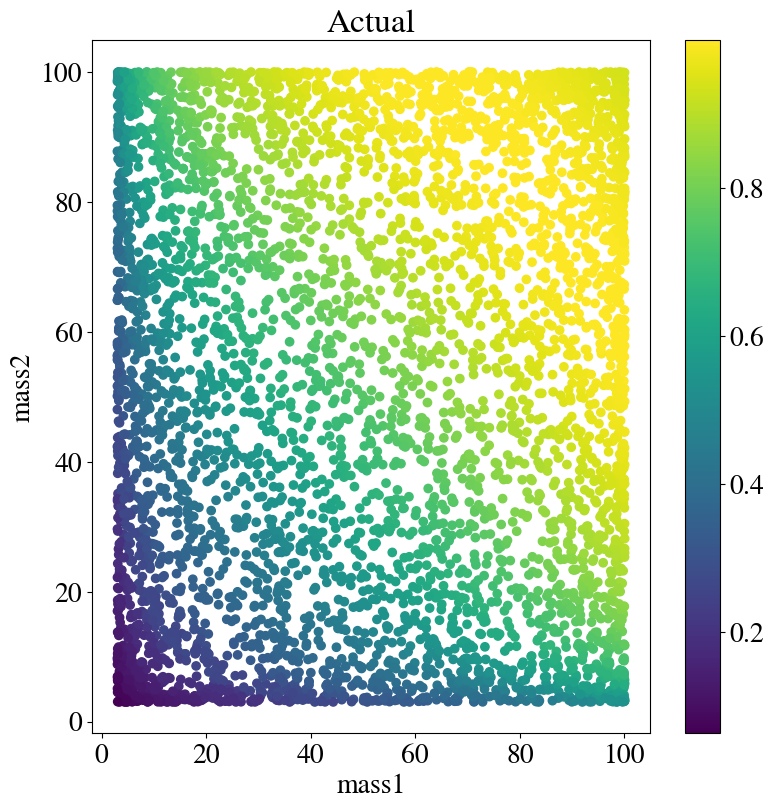

In [31]:
plt.figure(figsize=(9, 9))
plt.scatter(mass14, mass24, c=to_np(mass_y_test4), label='Actual')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Actual')
plt.colorbar()

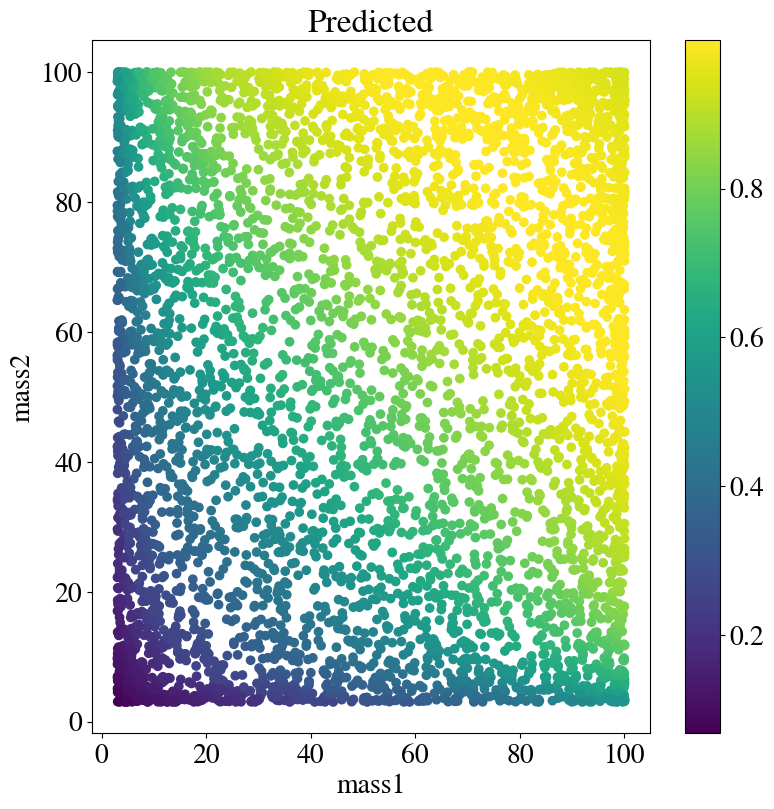

In [32]:
plt.figure(figsize=(9, 9))
plt.scatter(mass14, mass24, c=to_np(mass_y_prediction4))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()

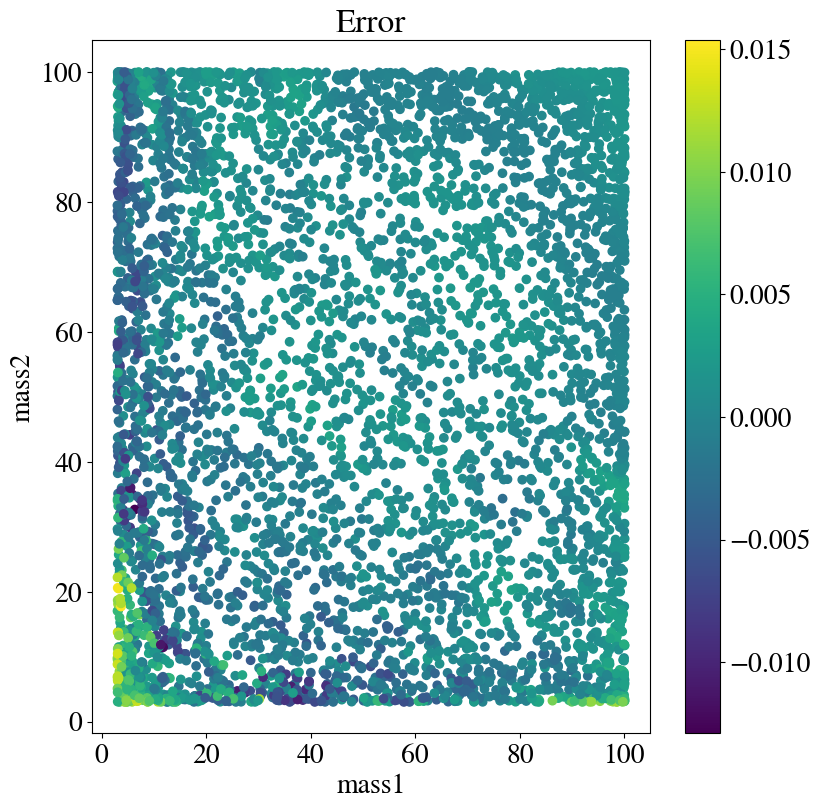

In [33]:
plt.figure(figsize=(9, 9))
plt.scatter(mass14, mass24, c=error4)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Error')
plt.colorbar()

### Reference Mass 29 and 36 with spins 0.7 and -0.6

In [34]:
mass_test_dataset5 = pd.read_csv(MASS_TEST_DATASET5)
mass_test_dataset5[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset5[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test5 = np.vstack((mass_test_dataset5.ref_mass1.values, mass_test_dataset5.ref_mass2.values, mass_test_dataset5.ref_spin1.values, mass_test_dataset5.ref_spin2.values, mass_test_dataset5.mass1.values, mass_test_dataset5.mass2.values, mass_test_dataset5.spin1.values, mass_test_dataset5.spin2.values)).T
mass_y_test5 = mass_test_dataset5.match.values

mass_x_test5 = torch.tensor(mass_x_test5, dtype=torch.float32, device='cpu')
mass_y_test5 = torch.tensor(mass_y_test5, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction5 = model(mass_x_test5) 
    
error5 = to_np(mass_y_prediction5[:, 0] - mass_y_test5)
x5 = to_np(mass_y_test5)

mass15 = rescaling_the_mass(to_np(mass_x_test5[:, 0]), scaler_mean, scaler_std)
mass25 = rescaling_the_mass(to_np(mass_x_test5[:, 1]), scaler_mean, scaler_std)

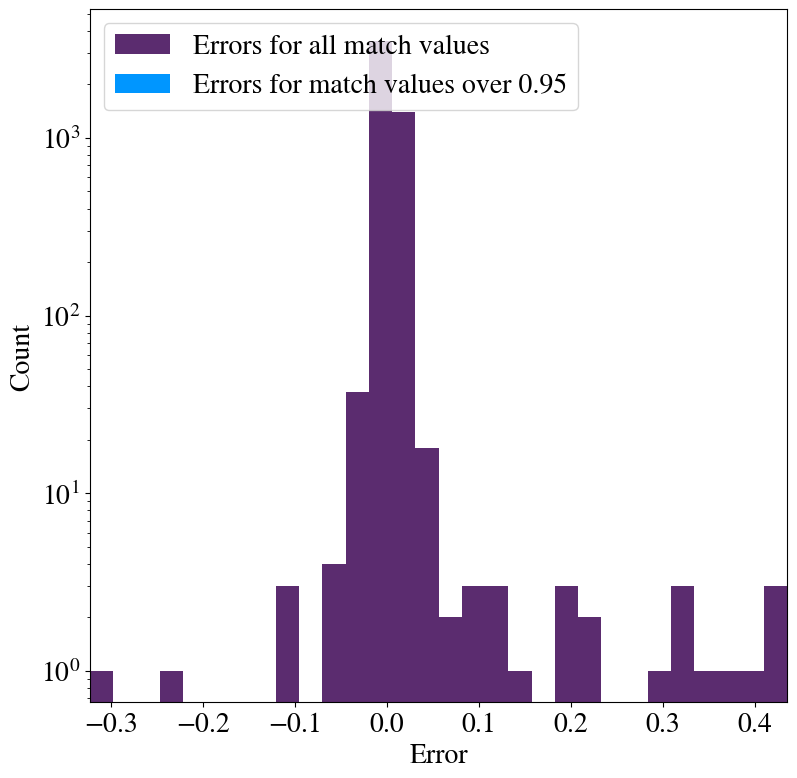

In [35]:
plt.figure(figsize=(9, 9))
plt.hist(error5, bins=30, range=[error5.min(), error5.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error5[x5 > .95], bins=30, range=[error5.min(), error5.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error5.min(), error5.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

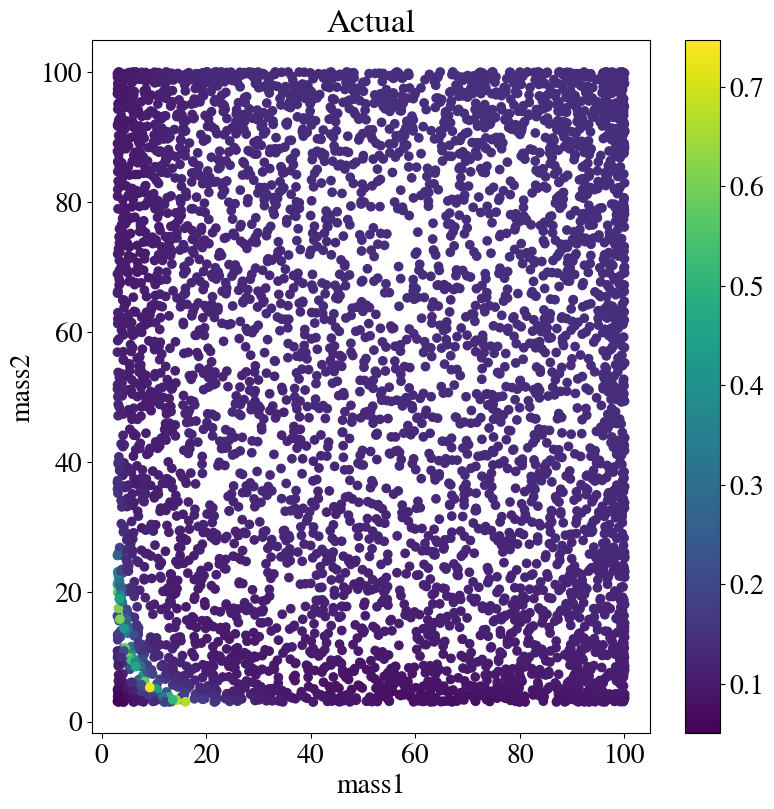

In [36]:
plt.figure(figsize=(9, 9))
plt.scatter(mass15, mass25, c=to_np(mass_y_test5), label='Actual')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Actual')
plt.colorbar()

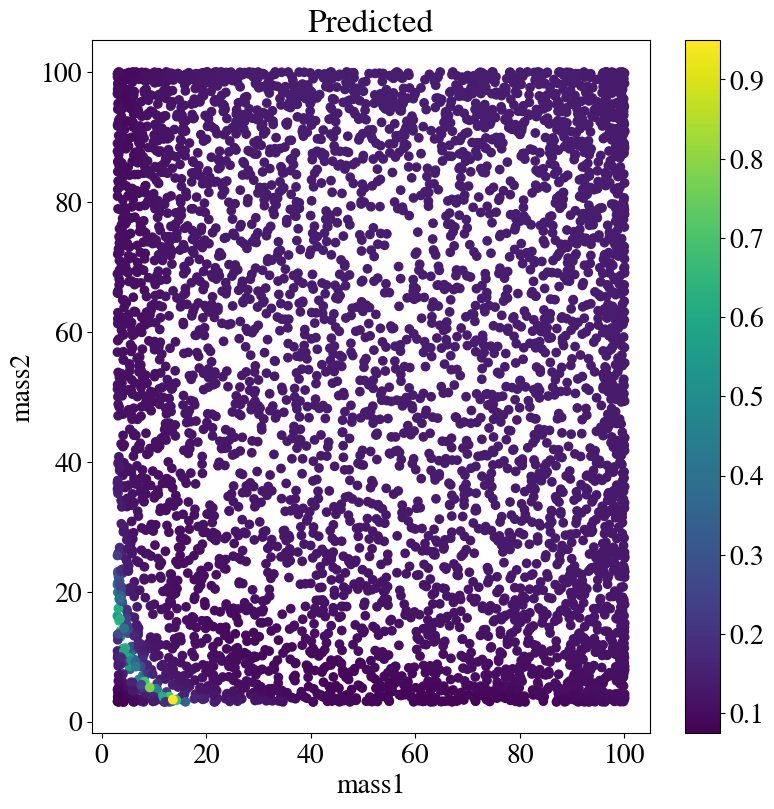

In [37]:
plt.figure(figsize=(9, 9))
plt.scatter(mass15, mass25, c=to_np(mass_y_prediction5))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()

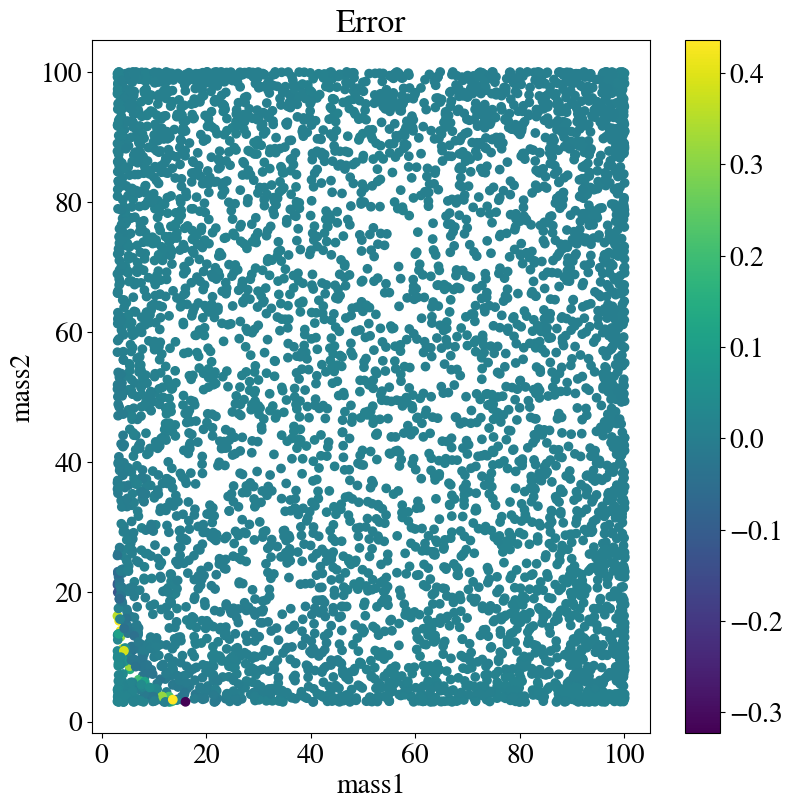

In [38]:
plt.figure(figsize=(9, 9))
plt.scatter(mass15, mass25, c=error5)
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Error')
plt.colorbar()

### Reference Mass 4 and 12 with spins -0.1 and 0.7 

In [39]:
mass_test_dataset6 = pd.read_csv(MASS_TEST_DATASET6)
mass_test_dataset6[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']] = scaler.transform(mass_test_dataset6[['ref_mass1', 'ref_mass2', 'mass1', 'mass2']])

mass_x_test6 = np.vstack((mass_test_dataset6.ref_mass1.values, mass_test_dataset6.ref_mass2.values, mass_test_dataset6.ref_spin1.values, mass_test_dataset6.ref_spin2.values, mass_test_dataset6.mass1.values, mass_test_dataset6.mass2.values, mass_test_dataset6.spin1.values, mass_test_dataset6.spin2.values)).T
mass_y_test6 = mass_test_dataset6.match.values

mass_x_test6 = torch.tensor(mass_x_test6, dtype=torch.float32, device='cpu')
mass_y_test6 = torch.tensor(mass_y_test6, dtype=torch.float32, device='cpu')

with torch.no_grad():
    mass_y_prediction6 = model(mass_x_test6) 
    
error6 = to_np(mass_y_prediction6[:, 0] - mass_y_test6)
x6 = to_np(mass_y_test6)

mass16 = rescaling_the_mass(to_np(mass_x_test6[:, 0]), scaler_mean, scaler_std)
mass26 = rescaling_the_mass(to_np(mass_x_test6[:, 1]), scaler_mean, scaler_std)

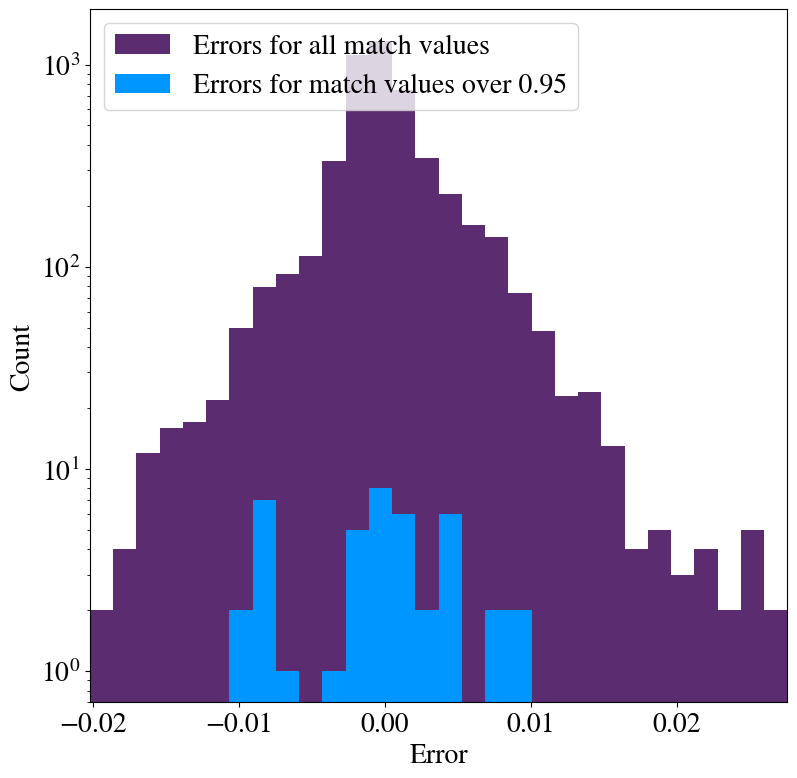

In [40]:
plt.figure(figsize=(9, 9))
plt.hist(error6, bins=30, range=[error6.min(), error6.max()], color='#5B2C6F', align='mid', label='Errors for all match values')
plt.hist(error6[x6 > .95], bins=30, range=[error6.min(), error6.max()], color='#0096FF', align='mid', label='Errors for match values over 0.95')
plt.xlim([error6.min(), error6.max()])
plt.yscale('log')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

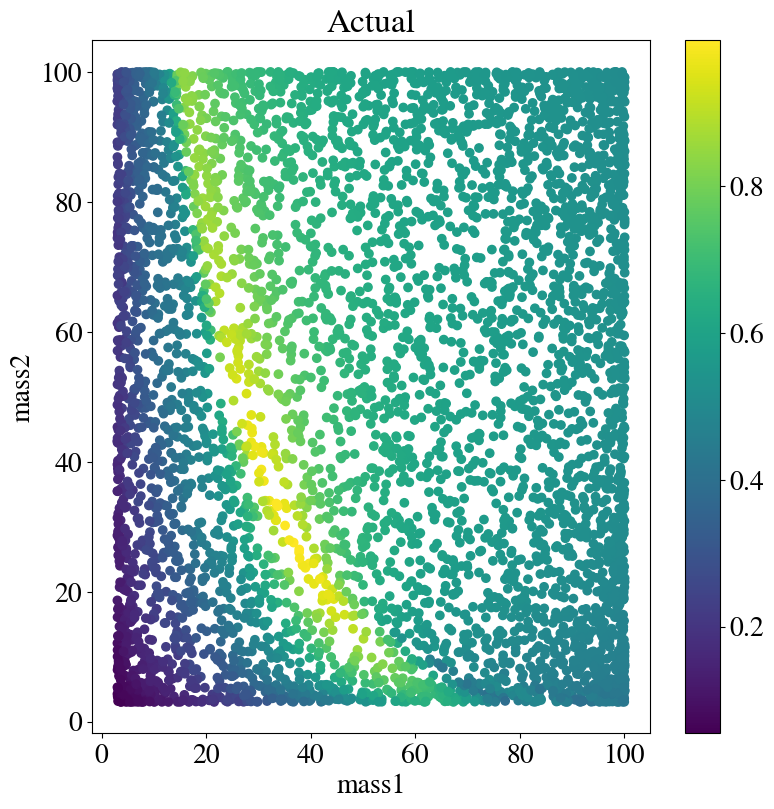

In [41]:
plt.figure(figsize=(9, 9))
plt.scatter(mass16, mass26, c=to_np(mass_y_test6), label='Actual')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Actual')
plt.colorbar()

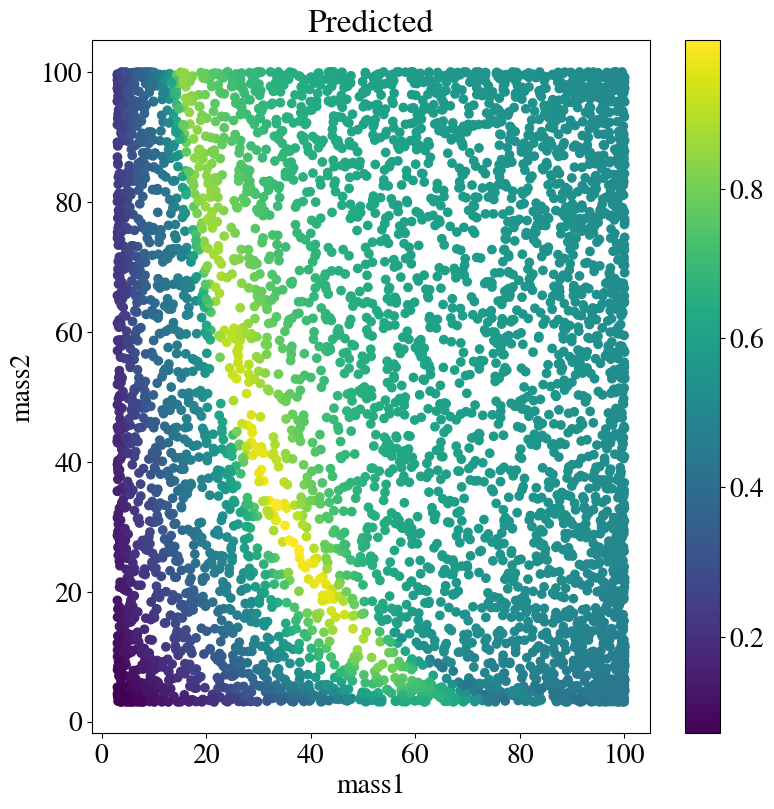

In [42]:
plt.figure(figsize=(9, 9))
plt.scatter(mass16, mass26, c=to_np(mass_y_prediction6))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.title('Predicted')
plt.colorbar()